# Driving a regression model towards under/overestimation with an asymmetric loss

In the context of regression, there are a few real-world situations in which users would rather get positive errors than negative ones (or the opposite), while still wanting estimations as accurate as possible:
* Forecasting supply needs for materials critical for production: you'd better have too much than be short
* Time to delivery: clients may be much more bothered by delay than by earlier-than-expected events 
* Estimating insurance premium: companies may overestimate costs rather than underestimate them to remain profitable

Let's implement a custom asymmetric loss for this purpose. We will use this [Kaggle dataset](https://www.kaggle.com/nehalbirla/motorcycle-dataset) about used motorcycles' prices. We will drive the regression model towards underpredicting values using the linear-exponential loss. This way, the bikes would generally be sold at a higher price than expected, while keeping accurate estimations on average. This approach is interesting from a seller's perspective as it tends to avoid bad surprises.

In [1]:
# Packages
import pandas as pd
import pyarrow
import numpy as np
import xgboost as xgb
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data
df=pd.read_csv('data.csv')
df.shape

(1061, 7)

In [3]:
# Missing values
df.isna().sum()

name                   0
selling_price          0
year                   0
seller_type            0
owner                  0
km_driven              0
ex_showroom_price    435
dtype: int64

We will not dive into missing values today, that is not the point of this post. [XGBoost can handle them as is](https://xgboost.readthedocs.io/en/stable/faq.html#:~:text=How%20to%20deal%20with%20missing%20values). Let's just keep in mind that nearly half the rows have empty showroom prices.

In [4]:
# Numerical features
df.describe()

,selling_price,year,km_driven,ex_showroom_price
count,1061.000000,1061.000000,1061.000000,6.260000e+02
mean,59638.151744,2013.867107,34359.833176,8.795871e+04
std,56304.291973,4.301191,51623.152702,7.749659e+04
min,5000.000000,1988.000000,350.000000,3.049000e+04
25%,28000.000000,2011.000000,13500.000000,5.485200e+04
50%,45000.000000,2015.000000,25000.000000,7.275250e+04
75%,70000.000000,2017.000000,43000.000000,8.703150e+04
max,760000.000000,2020.000000,880000.000000,1.278000e+06


The selling/showroom prices appear to be expressed in Indian rupees. I'll convert those in USD so it speaks more to me.

In [5]:
#Convert selling_price/ex_showroom_price to USD
inr_exchange_rate=0.013
df['selling_price']=df['selling_price']*inr_exchange_rate
df['ex_showroom_price']=df['ex_showroom_price']*inr_exchange_rate

In [6]:
df.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,2275.0,2019,Individual,1st owner,350,NaN
1,Honda Dio,585.0,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,1950.0,2018,Individual,1st owner,12000,1925.482
3,Yamaha Fazer FI V 2.0 [2016-2018],845.0,2015,Individual,1st owner,23000,1165.359
4,Yamaha SZ [2013-2014],260.0,2011,Individual,2nd owner,21000,NaN


In [7]:
# Retain only the brand from the model description
df['name']=df['name'].apply(lambda x: x.split(' ')[0])

In [8]:
# Categorical features
df.value_counts('name')

name
Bajaj              260
Hero               232
Honda              204
Royal              109
Yamaha             102
TVS                 69
Suzuki              30
KTM                 24
Mahindra             6
Vespa                4
Kawasaki             4
UM                   3
Activa               3
Jawa                 3
Aprilia              2
Harley-Davidson      2
Hyosung              1
Benelli              1
BMW                  1
Yo                   1
dtype: int64

In [9]:
df.value_counts('seller_type')

seller_type
Individual    1055
Dealer           6
dtype: int64

In [10]:
df.value_counts('owner')

owner
1st owner    924
2nd owner    123
3rd owner     11
4th owner      3
dtype: int64

Having rare categorical levels in the dataset can be very problematic, depending on the chosen encoding. If a given level is not seen by the model during training, but appears in the test set (or even worse, production), then the model can possibly fail to produce an output.

For the sake of simplicity, we'll use Leave-One-Out encoding: it can handle both [missing and unknown values](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html).

# An asymmetric cost function for regression: the linear-exponential loss

Surprisingly, I have found very little data about asymmetric loss functions **in the context of regression**. Most of the papers/threads I have came across mention variations of the standard quadratic loss (see [here](https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=ESAM09&paper_id=194) and [there](https://datascience.stackexchange.com/questions/10471/linear-regression-with-non-symmetric-cost-function)) or other impractical functions. Why impractical? Because these losses do not have "smooth" derivatives! This is unfortunate for us Machine Learning practioners, who abide by the almighty gradient descent approach.

[This paper [1]](https://www.scirp.org/journal/paperinformation.aspx?paperid=97986) and a few *Stack Overflow* / *Cross Validated* threads bring up the linear-exponential loss, sometime called LINEX. Let us denote it by ($lexp$). It is defined as follows:

$$lexp \colon E \longmapsto b \cdot [e^{a \cdot E} - a \cdot E - 1]$$

where $E$ is the difference between the observed value and the predicted value, i.e $E:=y-\hat{y}$.

When $a$ is close to 0, then $lx(E) \sim b \cdot \frac{a^2 \cdot E^2}{2} + o(E^2)$ (see Taylor series of $exp$). So, let us set $b=\frac{2}{a^2}$. This way, we will have $lexp(E) \approx E^2$ when $a$ is small. When $a$ increases, the "asymmetry" of the loss increases as well:

![linex](linex.gif "linex")

As this function is infinitely differentiable, it can very well be implemented as a custom loss in popular Machine Learning libraries: see with [PyTorch](https://neptune.ai/blog/pytorch-loss-functions#custom-pytorch-loss-function) or [Keras](https://keras.io/api/losses/#creating-custom-losses) for example. 

Let us give an XGBoost example. To train such a model with this custom loss, we will need to provide its first and second order derivatives with respect to the prediction $\hat{y}$ (see section 2.2 of the [XGBoost paper](https://arxiv.org/pdf/1603.02754.pdf), or the [example in the doc](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html)):

$$
\left\{
    \begin{array}\\
        lexp \ (y, \ \hat{y}) = \frac{2}{a^2} \cdot [e^{a \cdot (\hat{y}-y)} - a \cdot (\hat{y}-y) - 1] \\
        \frac{\partial \, lexp}{\partial \, \hat{y}}(y, \ \hat{y}) = \frac{2}{a} \cdot [e^{a \cdot (\hat{y}-y)} - 1] \\
        \frac{\partial^{2} \, lexp}{\partial \, {\hat{y}}^2}(y, \ \hat{y}) = 2 \cdot e^{a \cdot (\hat{y}-y)} \\
    \end{array}
\right.
$$

Here we have defined the error as the unconventional $\hat{y}-y$. The point is to avoid minus signs all over the place when computing derivatives. This will lead to penalize overestimations more than underestimation: overall, the model will underestimate. If we want to train the regressor the other way around, then we will swap $\hat{y}-y$ for the "usual" $y-\hat{y}$, keeping in mind the following high school classics:

$$
\left\{
    \begin{array}\\
        \frac{\partial}{\partial x}f(\text{-} x) = \text{-} f'(\text{-} x) \\
        \frac{\partial^2}{\partial x^2}f(\text{-} x) = f''(\text{-} x) \\
    \end{array}
\right.
$$

*Technical note: using 128-bit floats is advised when implementing this loss. Else overflow errors may arise because of skyrocketing values in the exponential.*

In [11]:
# Implement a custom loss for XGBoost
from typing import Tuple

def gradient_linex(predt: np.ndarray, dtrain: xgb.DMatrix, a=1e-3, mode='underestimate') -> np.ndarray:
    '''Compute the gradient of linear-exponential loss.'''
    y, predt, a = dtrain.get_label().astype('float128'), predt.astype('float128'), np.float128(a)
    if mode=='underestimate':
        return (2/a) * ( np.exp(a * (predt-y)) - 1 )
    else:
        return -(2/a) * ( np.exp(a * (y-predt)) - 1 )

def hessian_linex(predt: np.ndarray, dtrain: xgb.DMatrix, a=1e-3, mode='underestimate') -> np.ndarray:
    '''Compute the hessian of linear-exponential loss.'''
    y, predt, a = dtrain.get_label().astype('float128'), predt.astype('float128'), np.float128(a)
    if mode=='underestimate':
        return 2 * np.exp( a * (predt-y) )
    else:
        return 2 * np.exp( a * (y-predt) )
    return np.float128(h)

def linex(predt: np.ndarray, dtrain: xgb.DMatrix, a=1e-3, mode='underestimate') -> Tuple[np.ndarray, np.ndarray]:
    '''Linear-exponential loss.'''
    grad = gradient_linex(predt, dtrain, a=a, mode=mode)
    hess = hessian_linex(predt, dtrain, a=a, mode=mode)
    return grad, hess

def get_linex_function(a=1e-3, mode='underestimate'):
    """returns the linex function with fixed parameters ``a`` and ``mode``."""
    return lambda predt, dtrain: linex(predt, dtrain, a=a, mode=mode)

In [12]:
# Leave-One-Out encoding
def encode_train(df, target, cols):
    """Leave-One-Encode the train set and returns the corresponding encoder."""
    df_float = df.drop(columns=cols)
    df_category = df[cols]
    encoder = LeaveOneOutEncoder()
    df_encoded = encoder.fit_transform(df_category, target)
    df = pd.concat([df_float,df_encoded], axis = 1)
    return df, encoder

def encode_test(df, encoder, cols):
    """Leave-One-Encode the test set using a fitted encoder."""
    df_float = df.drop(columns=cols)
    df_category = df[cols]
    df_encoded = encoder.transform(df_category)
    df = pd.concat([df_float, df_encoded], axis = 1)
    return df

# Train-val-test splitting
def make_datasets(df=df, target='selling_price', colums_to_encode=['name', 'seller_type', 'owner', 'ex_showroom_price'], random_state=42):
    """Build a train, validation and test sets from the full dataset."""
    # (Train)-(val+test) split
    x, y = df.drop(columns=target), df[target]
    x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=random_state)
    # Encode
    x_train, encoder = encode_train(df=x_train, target=y_train, cols=colums_to_encode)
    x_val_test = encode_test(df=x_val_test, encoder=encoder, cols=colums_to_encode)
    # Normalize
    x_min, x_max, y_min, y_max=x_train.min(), x_train.max(), y_train.min(), y_train.max()
    x_train, x_val_test = (x_train - x_min) / (x_max - x_min), (x_val_test - x_min) / (x_max - x_min)
    y_train, y_val_test = (y_train - y_min) / (y_max - y_min), (y_val_test - y_min) / (y_max - y_min)
    # Val-test split
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_state)
    # Format for XGBoost
    train_xgb = xgb.DMatrix(x_train, label = y_train)
    val_xgb= xgb.DMatrix(x_val, label = y_val)
    test_xgb = xgb.DMatrix(x_test, label = y_test)
    
    return train_xgb, val_xgb, test_xgb, y_min, y_max

# Train XGBoost models
def build_xgb_model(
    verbose_eval=0,
    seed_xgb=42,
    seed_data_split=42,
    early_stopping_rounds=3,
    objective='reg:squarederror',
    a=1e-3,
    mode='underestimate',
    num_trees=30,
    booster='gbtree',
    tree_method='exact',
    eta=0.3, #[0,1]
    gamma=0, #[0,+Inf]
    max_depth=6, #[0,+Inf]
    min_child_weight=1, #[0,+Inf]
    subsample=1, #(0,1]
    colsample_bytree=1 #(0,1]
):
    """Make a train-val-test split of the data, train a model according to input parameters and returns test residuals."""
    train_xgb, val_xgb, test_xgb, y_min, y_max = make_datasets(random_state=seed_data_split)
    
    params={
        'booster': booster,
        'tree_method': tree_method,
        'seed': seed_xgb,
        'eta': eta,
        'gamma': gamma,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
        }
    
    results={}
        
    if objective=='linex':
        xgbm = xgb.train(params = params,
                         dtrain = train_xgb,
                         obj=get_linex_function(a=a, mode=mode),
                         evals=[(train_xgb, 'train_xgb'), (val_xgb, 'val_xgb')],
                         evals_result=results,
                         num_boost_round = num_trees,
                         early_stopping_rounds=early_stopping_rounds,
                         verbose_eval=verbose_eval)
    else:
        params['objective']=objective
        xgbm = xgb.train(params = params,
                         dtrain = train_xgb,
                         evals=[(train_xgb, 'train_xgb'), (val_xgb, 'val_xgb')],
                         evals_result=results,
                         num_boost_round = num_trees,
                         early_stopping_rounds=early_stopping_rounds,
                         verbose_eval=verbose_eval)
    
    predictions=(xgbm.predict(test_xgb) * (y_max - y_min)) + y_min
    actual_values=(test_xgb.get_label() * (y_max - y_min)) + y_min
    
    return (actual_values-predictions).tolist()

# Results (RMSE and other metrics) are very dependent on the train-test split because of the limited number of rows available.
# In order to get a better estimation of the error distribution, we use the following function:
def get_bootstrapped_residuals(n, a_values):
    """Run build_xgb_model() ``n`` times, i.e on ``n`` random train-test splits."""
    seeds=np.random.randint(1e6, size=n)
    residuals_collection=pd.DataFrame()
    for a in a_values:
        with open('progress.txt', 'w') as f:
            f.write(f'a = {a:.2f}')
        linex_residuals, se_residuals=[], []
        for seed in seeds:
            linex_residuals.extend(build_xgb_model(seed_data_split=seed, objective='linex', a=a))
            se_residuals.extend(build_xgb_model(seed_data_split=seed))
        residuals_a= pd.DataFrame({
            'a': a,
            'Loss': ['Linear-exponential Error']*len(linex_residuals)+['Squared Error']*len(linex_residuals),
            'Residual': linex_residuals+se_residuals
        })
        residuals_collection=residuals_collection.append(residuals_a, ignore_index=True)
    return(residuals_collection)

In [13]:
# bootstrapped_residuals=get_bootstrapped_residuals(n=500, a_values=np.round(np.arange(10, 35.05, 0.05), 2))
# bootstrapped_residuals.to_parquet('bootstrapped_residuals.parquet', engine='pyarrow')

In [14]:
bootstrapped_residuals=pd.read_parquet('bootstrapped_residuals.parquet')

In [15]:
bootstrapped_residuals

,a,Loss,Residual
0,10.0,Linear-exponential Error,771.342834
1,10.0,Linear-exponential Error,-372.657166
2,10.0,Linear-exponential Error,-138.657166
3,10.0,Linear-exponential Error,316.342834
4,10.0,Linear-exponential Error,-528.657166
...,...,...,...
159995,35.0,Squared Error,-483.310669
159996,35.0,Squared Error,1037.689331
159997,35.0,Squared Error,-158.310669
159998,35.0,Squared Error,-457.310669


In [16]:
def rmse(error):
    """Compute the Root Mean Squared Error of an array of errors."""
    return( np.sqrt(np.mean(np.square(error))) )

def get_percentile_function(n):
    """Returns the ``n``th percentile function"""
    def percentile(x):
        return np.percentile(x, n)
    percentile.__name__ = f'percentile_{n}'
    return percentile

def get_metrics(percentile=95, melted=True):
    metrics=bootstrapped_residuals.groupby(['a', 'Loss'], as_index=False)\
        .agg({
            # 'Residual': [rmse, 'mean', 'std', get_percentile_function(percentile)],
            'Residual': [rmse, 'mean', 'median', get_percentile_function(percentile)],
        })\
        .reset_index(drop=True)

    # metrics.columns=['a', 'Loss', 'RMSE', 'Mean', 'Standard Deviation', percentile_str]
    percentile_str=str(percentile)+'th Percentile'
    metrics.columns=['a', 'Loss', 'RMSE', 'Mean', 'Median', percentile_str]
    
    if melted:
        return pd.melt(frame=metrics,
                       id_vars=['a', 'Loss'],
                       # value_vars=['RMSE', 'Mean', 'Standard Deviation', percentile_str],
                       value_vars=['RMSE', 'Mean', 'Median', percentile_str],
                       var_name='Metric',
                       value_name='Value'
                      )
    else:
        return metrics

# Results

Let us compare the usual squared error and the linear-exponential loss using a few metrics: RMSE, mean, median and 95<sup>th</sup> percentile of the residuals on the test set. These numbers are very dependent on the train-test split because the dataset is very small. In order to get stable values, we use the following method:

* For each $a$ value:
    * Make a random train-test split
    * Build a squared-error-loss model and a linear-exponential-loss model, retrieve residuals
    * Repeat 500 times
    * Compute aggregated metrics over the entire collection of residuals


*Note: we did not perform hyperparameter tuning as accuracy is not the purpose of this experiment. Default values are used for both the losses.*

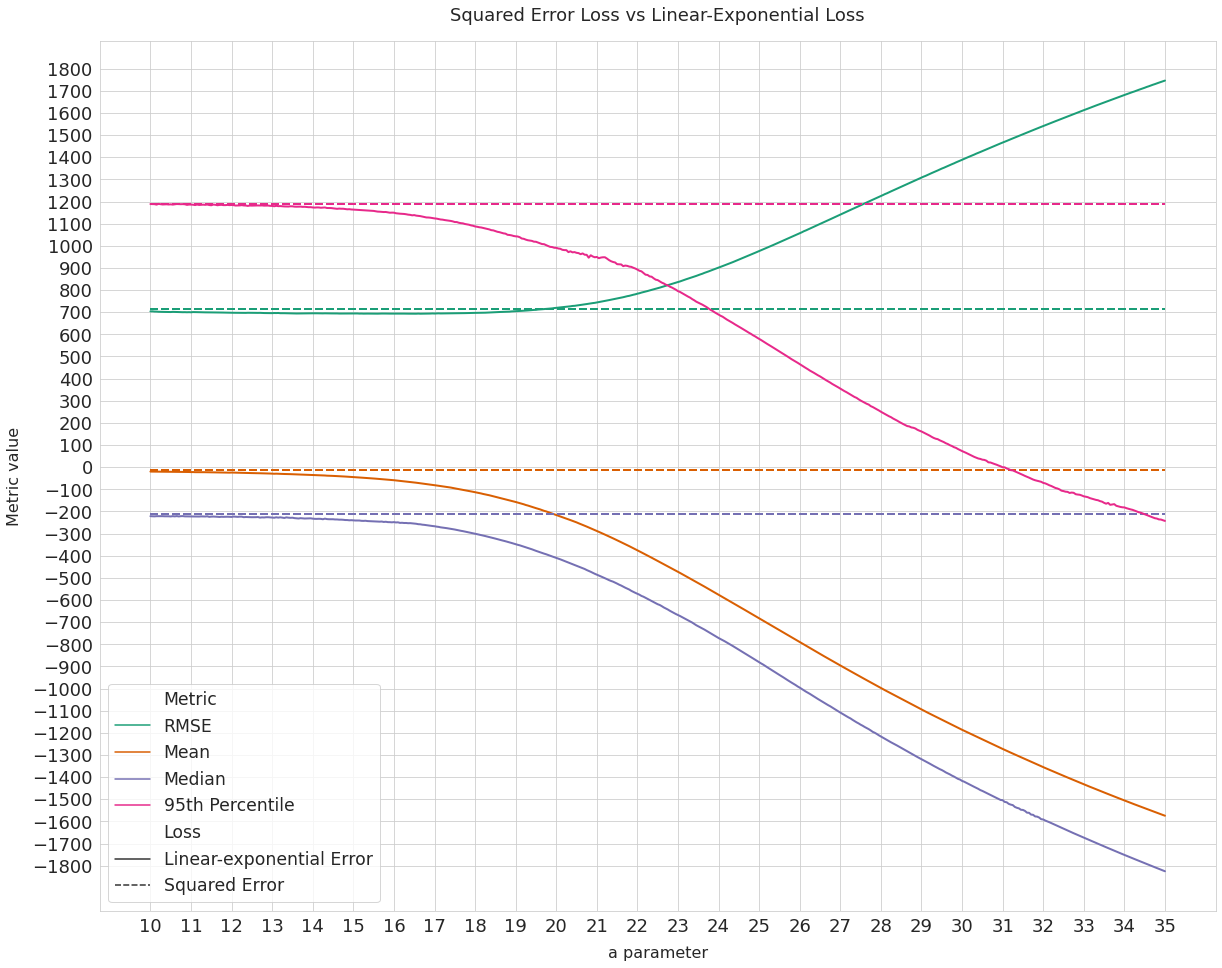

In [17]:
percentile=95

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 16))
ax=sns.lineplot(
    x='a',
    y='Value',
    hue='Metric',
    style='Loss',
    linewidth=2,
    data=get_metrics(percentile),
    palette='Dark2'
    )

ax.set_title('Squared Error Loss vs Linear-Exponential Loss', fontsize=18, pad=20)
ax.set_xlabel('a parameter', fontsize = 16, labelpad = 10)
ax.set_ylabel('Metric value', fontsize = 16, labelpad = 10)
ax.set_xticks(range(10, 35+1))
ax.set_yticks(range(-1800, 1900, 100))
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc='lower left', fontsize='xx-large');

In [18]:
fig.figure.savefig("results.png", format='png')

There is an interesting phenomenon happening between $a \approx 13$ and $a \approx 20$: the mean/median/perc. 95 start decreasing but the overall RMSE does not degrade. In other words, we are actually achieving **underestimation without degrading the accuracy** of the model.

When $a=20$, the RMSE is the same for the two losses but the prices are estimated \\$200 lower, on average. This means the linear-exponential loss allows the errors distribution to be **skewed**. Actually, in this case the squared-error-loss residuals are initially skewed to the right, as shown below. The linear-exponential loss "unskews" the residuals to the left.

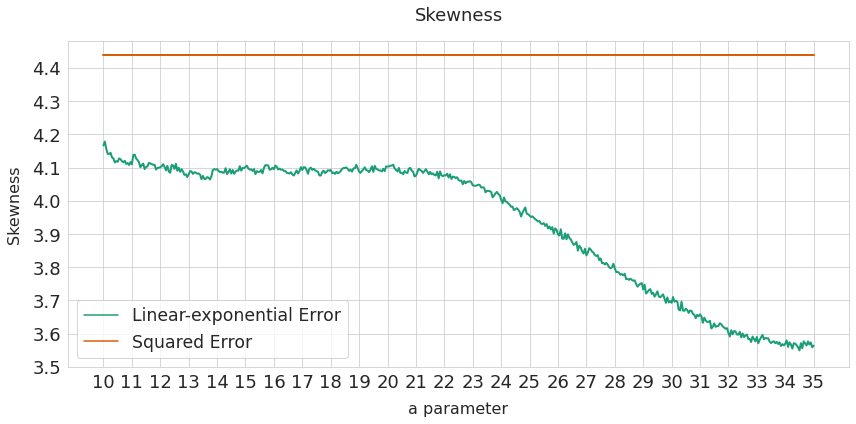

In [19]:
skewness=bootstrapped_residuals.groupby(['a', 'Loss'], as_index=False)\
    .agg({
        'Residual': ['skew'],
    })\
    .reset_index(drop=True)
skewness.columns=['a', 'Loss', 'Skewness']

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))
ax=sns.lineplot(
    x='a',
    y='Skewness',
    hue='Loss',
    linewidth=2,
    data=skewness,
    palette='Dark2'
    )

ax.set_title('Skewness', fontsize=18, pad=20)
ax.set_xlabel('a parameter', fontsize = 16, labelpad = 10)
ax.set_ylabel('Skewness', fontsize = 16, labelpad = 10)
ax.set_xticks(range(10, 35+1))
ax.set_yticks(np.arange(3.5, 4.5, 0.1))
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc='lower left', fontsize='xx-large');

In [20]:
fig.figure.savefig("skewness.png", format='png')

# An overcomplicated solution?

Recall that the point of all this is to drive the model towards underestimation, without loosing accuracy if possible. The linear-exponential loss is asymmetric (--> underestimation) but still aims at achieving 0 error (--> accuracy). These two characteristics appear to make this loss successful in that matter.

What if, instead of implementing this complicated custom loss, we just lowered the predictions by a fixed quantity? On the basis that the squared-loss errors average to 0 on the test set, we could just subtract \\$100 to every prediction to achieve on overall underprediction of \\$100, on average. Now, we are doing underestimation without aiming at the actual price, but aiming at a -\\$100 error, on average. That is why I call such a loss a *decentered* squared error loss.

Below are the RMSEs of both losses (linear-exponential/decentered squared) when they achieve the same mean error. For instance, when both losses are adjusted to yield a -\\$100 average underestimation on the test set, the linear-exponential loss' RMSE is about \\$695, whereas the decentered loss' RMSE is about \\$721.

Although it is difficult to determine if the gap observed below is significant or not without further analysis (other datasets, other hyperparameter tunings...), this piece of information seems to be in favor of the linear-exponential loss' relevance. An additional remark: when the average test error starts decreasing (read the plot from right to left), the decentered loss' RMSE increases straight away, whereas the linex loss' RMSE decreases first, before rising up again. So, with the linex loss, there is an interesting **tradeoff between underestimation and accuracy**.

In [21]:
def get_rmse_of_decentered_errors(a):
    target_mean=bootstrapped_residuals[(bootstrapped_residuals['a']==a) & (bootstrapped_residuals['Loss']=='Linear-exponential Error')]['Residual'].to_numpy().mean()
    squared_loss_residuals=bootstrapped_residuals[(bootstrapped_residuals['a']==a) & (bootstrapped_residuals['Loss']=='Squared Error')]['Residual'].to_numpy()
    squared_loss_residuals=squared_loss_residuals-(squared_loss_residuals.mean()-np.float64(target_mean))
    return rmse(squared_loss_residuals)

# metrics=get_metrics(melted=False)
# metrics=metrics[metrics['Loss']=='Linear-exponential Error'].drop(columns=['Loss', 'Median', '95th Percentile'])
# metrics['RMSE - Decentered Loss']=metrics['a'].apply(get_rmse_of_decentered_errors)
# metrics.to_csv('linex_decentered_squared_comparison.csv', index=False)

In [22]:
metrics=pd.read_csv('linex_decentered_squared_comparison.csv')
metrics.head()

,a,RMSE,Mean,RMSE - Decentered Loss
0,10.00,703.839425,-19.757965,713.974762
1,10.05,704.040818,-19.846799,713.977226
2,10.10,703.056629,-19.885729,713.978309
3,10.15,702.874094,-19.969423,713.980645
4,10.20,702.074845,-20.398878,713.992785


In [23]:
metrics_plot=metrics.drop(columns=['a'])\
.rename(columns={'RMSE': 'Linear-Exponential Loss', 'Mean': 'Average Error', 'RMSE - Decentered Loss': 'Decentered Squared Loss'})

metrics_plot=pd.melt(
    frame=metrics_plot,
    id_vars=['Average Error'],
    value_vars=['Linear-Exponential Loss', 'Decentered Squared Loss'],
    var_name='Loss',
    value_name='RMSE'
)

In [24]:
metrics_plot[(metrics_plot['Average Error']<=-99) & (metrics_plot['Average Error']>=-101)]

,Average Error,Loss,RMSE
153,-100.790723,Linear-Exponential Loss,695.127990
654,-100.790723,Decentered Squared Loss,720.783153


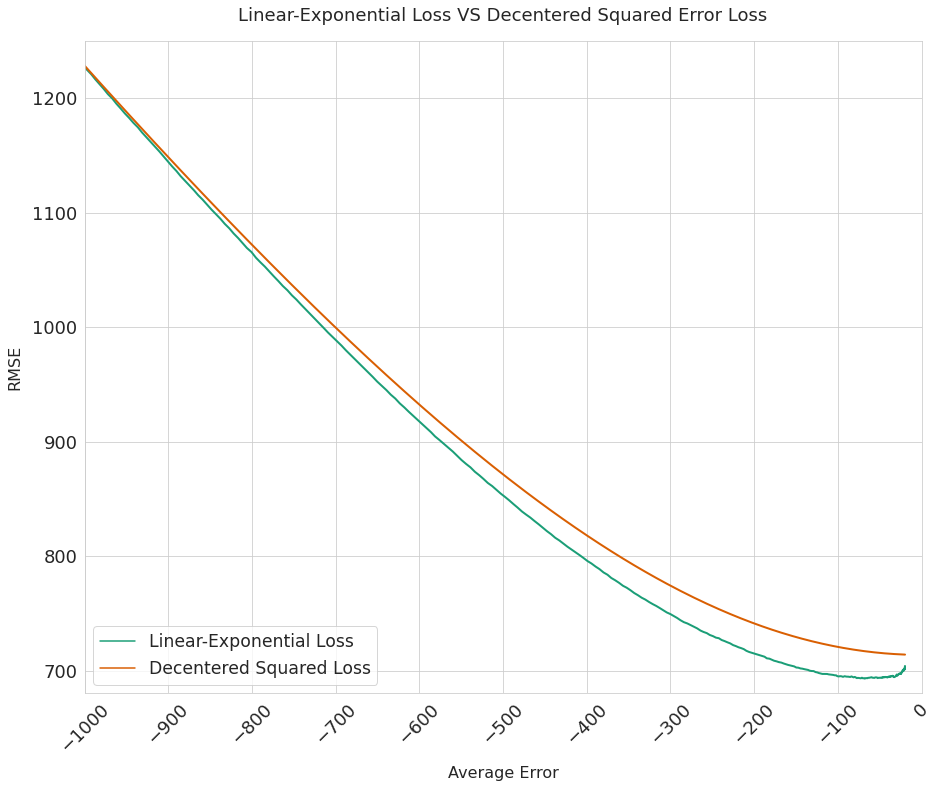

In [25]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 12))
ax=sns.lineplot(
    x='Average Error',
    y='RMSE',
    hue='Loss',
    linewidth=2,
    data=metrics_plot,
    palette='Dark2'
    )

ax.set_title('Linear-Exponential Loss VS Decentered Squared Error Loss', fontsize=18, pad=20)
ax.set_xlabel('Average Error', fontsize = 16, labelpad = 10)
ax.set_ylabel('RMSE', fontsize = 16, labelpad = 10)
ax.set_xticks(range(100, -1100, -100))
plt.xticks(rotation=45)
ax.set_yticks(range(700, 1300, 100))
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlim((-1000, 0))
ax.set_ylim((680, 1250))
ax.legend(loc='lower left', fontsize='xx-large');

In [26]:
fig.figure.savefig("decentered_squared_rmse.png", format='png')

# Conclusion

Coming back to our used motorcycles prices. When a=19.65, the RMSE is the same wether the model is trained with the usual squared error loss or with the linear-exponential loss. However, the predictions are lowered by 180 dollars, on average. See the distributions of the residuals below.

So, we have been able to drive our model towards underestimation, without sacrificing accuracy. Even more underestimation could be achieved by increasing the parameter a, but thi

In [27]:
metrics_squared_linex=get_metrics(95)

In [28]:
metrics_squared_linex[metrics_squared_linex['a']==19.65]

,a,Loss,Metric,Value
386,19.65,Linear-exponential Error,RMSE,713.416415
387,19.65,Squared Error,RMSE,713.833217
1388,19.65,Linear-exponential Error,Mean,-193.717399
1389,19.65,Squared Error,Mean,-13.721456
2390,19.65,Linear-exponential Error,Median,-387.049988
2391,19.65,Squared Error,Median,-212.992126
3392,19.65,Linear-exponential Error,95th Percentile,1007.836002
3393,19.65,Squared Error,95th Percentile,1188.099487


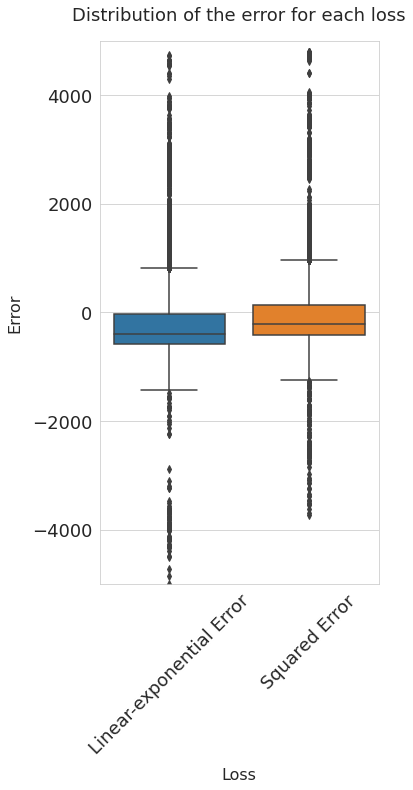

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot boxplots with seaborn
fig, ax = plt.subplots(figsize=(5, 10))
ax=sns.boxplot(
    x='Loss',
    y='Residual',
    data=bootstrapped_residuals[bootstrapped_residuals['a']==19.65],
    orient='v'
    )

ax.set_title('Distribution of the error for each loss', fontsize=18, pad=20)
ax.set_xlabel('Loss', fontsize = 16, labelpad = 10)
ax.set_ylabel('Error', fontsize = 16, labelpad = 10)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim((-5000, 5000))
plt.xticks(rotation=45);

In [30]:
fig.figure.savefig("conclusion.png", format='png')

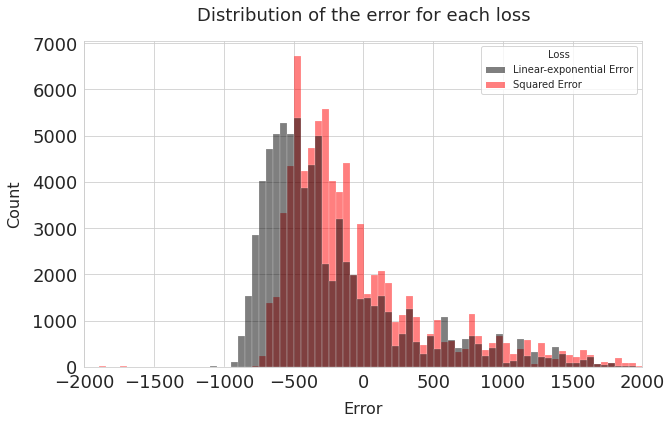

In [31]:
# Plot histograms with seaborn
fig, ax = plt.subplots(figsize=(10, 6))

palette = {"Squared Error":"red",
           "Linear-exponential Error":"black"}

ax=sns.histplot(
    x='Residual',
    hue='Loss',
    binwidth=50,
    multiple='layer',
    data=bootstrapped_residuals[bootstrapped_residuals['a']==19.65],
    palette=palette
    )

ax.set(xlim=(-2000, 2000))
ax.set_title('Distribution of the error for each loss', fontsize=18, pad=20)
ax.set_xlabel('Error', fontsize = 16, labelpad = 10)
ax.set_ylabel('Count', fontsize = 16, labelpad = 10)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18);

# References

[[1](https://www.scirp.org/journal/paperinformation.aspx?paperid=97986)] N. Khatun, M. A. Matin. *A Study on LINEX Loss Function with Different Estimating Methods*. Department of Statistics, Jahangirnagar University, Savar, Dhaka, Bangladesh, 2020.